In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns

In [2]:
df = pd.read_csv('pres-data.csv', index_col=0).reset_index().query("year < 2021")
df = df.rename({
    'Housing Inventory: Median Listing Price':'med_housing',
    'Unemployment Rate':'unemployment',
    'All Employees: Federal Government	Housing Inventory: Median Home Size in ':'govt_employees',
    'Housing Inventory: Median Days on Market':'housing_mkt_days',
    'Housing Inventory: New Listing Count':'housing_listings',
    'All Employees: Financial Activities':'financial_act',
    'All Employees: Education and Health Services':'educ_health',
    'All Employees: Federal Government':'fed_employees',
    'Resident Population':'population',
    'Per Capita Personal Income':'income',
    'Housing Inventory: Median Home Size in Square Feet':'home_size'
}, axis=1)

df.insert(0, 'year_month', df.year + df.month/100)

df = df.drop(columns=[
        'financial_act',
        'fed_employees',
        'educ_health',
        'income',
        'unemployment',
        'home_size',
        'housing_mkt_days'
])

df

,year_month,year,month,city,state,med_housing,housing_listings,population
0,2016.07,2016,7,Atlanta,GA,272000.0,14848.0,5791.874
1,2016.08,2016,8,Atlanta,GA,269900.0,13340.0,5791.874
2,2016.09,2016,9,Atlanta,GA,270168.0,13404.0,5791.874
3,2016.10,2016,10,Atlanta,GA,269900.0,12996.0,5791.874
4,2016.11,2016,11,Atlanta,GA,269900.0,10848.0,5791.874
...,...,...,...,...,...,...,...,...
244,2020.08,2020,8,Tulsa,OK,282000.0,1112.0,1006.411
245,2020.09,2020,9,Tulsa,OK,281250.0,1036.0,1006.411
246,2020.10,2020,10,Tulsa,OK,275000.0,1048.0,1006.411
247,2020.11,2020,11,Tulsa,OK,267450.0,992.0,1006.411


In [3]:
order = 3

predictors=list(df.columns)[5:]

output='med_zhvi'
predictors

['med_housing', 'housing_listings', 'population']

In [4]:
df.query("city=='Tulsa'").head(10)

,year_month,year,month,city,state,med_housing,housing_listings,population
195,2016.07,2016,7,Tulsa,OK,207000.0,1468.0,989.124
196,2016.08,2016,8,Tulsa,OK,207000.0,1448.0,989.124
197,2016.09,2016,9,Tulsa,OK,199950.0,1376.0,989.124
198,2016.10,2016,10,Tulsa,OK,197900.0,1316.0,989.124
199,2016.11,2016,11,Tulsa,OK,195000.0,1240.0,989.124
200,2016.12,2016,12,Tulsa,OK,192000.0,900.0,989.124
201,2017.01,2017,1,Tulsa,OK,196500.0,1332.0,991.785
202,2017.02,2017,2,Tulsa,OK,199949.5,1496.0,991.785
203,2017.03,2017,3,Tulsa,OK,203768.5,1612.0,991.785
204,2017.04,2017,4,Tulsa,OK,210000.0,1592.0,991.785


We're doing modified autoregression because we're not estimating all of our predictors, we won't have a **prediction** past the next year unless we had a prediction for all of our predictors as well that we could feed back into the model. We'll either only be predicting for the next time slot or we'll have to come up with posterior models for each predictor to then feed back into the model. 

In [5]:
def generate_time_data(df, city, order, predictors):

  df = df.query(F"city== '{city}'").reset_index(drop=True)

  df_input = pd.DataFrame()

  year_months = []

  for period in range(order, len(df)):
    year_month = df.year_month.loc[period]
    # print(year_month)
    df2 = df.loc[period-order:period-1]
    # print(df2)

    df2['step'] = [i for i in range(order)]
    df_pivot = df2.pivot(index='city', columns='step', values=predictors).reset_index()
    df_pivot.columns = [col[0]+"_"+str(col[1]) for col in df_pivot.columns]
    # print(df_pivot)

    # Get relevant outputs
    query = F"year_month == {year_month}"
    for col in predictors:
      df_pivot[col] = df.query(query).reset_index(drop=True)[col].iloc[0]

    df_input = pd.concat([df_input, df_pivot])
    year_months.append(year_month)

  # print(df_input)

  df_input.insert(1, 'year_month',year_months)
  df_input = df_input.reset_index(drop=True)
  # df_input.columns=[str(col[0]) + str(col[1]) for col in df_input.columns.values]
  return df_input

generate_time_data(df=df, city='Tulsa',order=4, predictors = predictors).head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,med_housing_2,med_housing_3,housing_listings_0,housing_listings_1,housing_listings_2,housing_listings_3,population_0,population_1,population_2,population_3,med_housing,housing_listings,population
0,Tulsa,2016.11,207000.0,207000.0,199950.0,197900.0,1468.0,1448.0,1376.0,1316.0,989.124,989.124,989.124,989.124,195000.0,1240.0,989.124
1,Tulsa,2016.12,207000.0,199950.0,197900.0,195000.0,1448.0,1376.0,1316.0,1240.0,989.124,989.124,989.124,989.124,192000.0,900.0,989.124
2,Tulsa,2017.01,199950.0,197900.0,195000.0,192000.0,1376.0,1316.0,1240.0,900.0,989.124,989.124,989.124,989.124,196500.0,1332.0,991.785
3,Tulsa,2017.02,197900.0,195000.0,192000.0,196500.0,1316.0,1240.0,900.0,1332.0,989.124,989.124,989.124,991.785,199949.5,1496.0,991.785
4,Tulsa,2017.03,195000.0,192000.0,196500.0,199949.5,1240.0,900.0,1332.0,1496.0,989.124,989.124,991.785,991.785,203768.5,1612.0,991.785
5,Tulsa,2017.04,192000.0,196500.0,199949.5,203768.5,900.0,1332.0,1496.0,1612.0,989.124,991.785,991.785,991.785,210000.0,1592.0,991.785
6,Tulsa,2017.05,196500.0,199949.5,203768.5,210000.0,1332.0,1496.0,1612.0,1592.0,991.785,991.785,991.785,991.785,214500.0,1656.0,991.785
7,Tulsa,2017.06,199949.5,203768.5,210000.0,214500.0,1496.0,1612.0,1592.0,1656.0,991.785,991.785,991.785,991.785,219250.0,1612.0,991.785
8,Tulsa,2017.07,203768.5,210000.0,214500.0,219250.0,1612.0,1592.0,1656.0,1612.0,991.785,991.785,991.785,991.785,215000.0,1612.0,991.785
9,Tulsa,2017.08,210000.0,214500.0,219250.0,215000.0,1592.0,1656.0,1612.0,1612.0,991.785,991.785,991.785,991.785,219200.0,1440.0,991.785


## Format Data for model input

In [6]:
input = generate_time_data(df=df, city='Tulsa',order=2, predictors = predictors)
input.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,housing_listings_0,housing_listings_1,population_0,population_1,med_housing,housing_listings,population
0,Tulsa,2016.09,207000.0,207000.0,1468.0,1448.0,989.124,989.124,199950.0,1376.0,989.124
1,Tulsa,2016.10,207000.0,199950.0,1448.0,1376.0,989.124,989.124,197900.0,1316.0,989.124
2,Tulsa,2016.11,199950.0,197900.0,1376.0,1316.0,989.124,989.124,195000.0,1240.0,989.124
3,Tulsa,2016.12,197900.0,195000.0,1316.0,1240.0,989.124,989.124,192000.0,900.0,989.124
4,Tulsa,2017.01,195000.0,192000.0,1240.0,900.0,989.124,989.124,196500.0,1332.0,991.785


In [7]:
nums = ['0','1','2','3','4','5','6','7','8','9']
columns = [col for col in input.columns if col[-1] in nums]
outputs = [col for col in input.columns[2:] if col[-1] not in nums]

for output in outputs:
  print(F"\t# {output}")
  input_names = []
  for col in columns:
    input_names.append(F"{col}_{output}")
    print(F"\t{col}_{output} = pm.Normal(name='{col}_{output}', mu=0, sigma=sig)")
    # print("")
  print("")
  print(F"\ttheta_{output} = (")  
  for name in columns:
    if name == columns[-1]:
      print(F"\t\t{name}_{output}*input.{name}")
    else:   
      print(F"\t\t{name}_{output}*input.{name}+")
  print("\t)")

  print(F"\t{output} = pm.Normal('{output}', theta_{output}, sd=200, observed=input.{output})")

  print("")


	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	population_0_med_housing = pm.Normal(name='population_0_med_housing', mu=0, sigma=sig)
	population_1_med_housing = pm.Normal(name='population_1_med_housing', mu=0, sigma=sig)

	theta_med_housing = (
		med_housing_0_med_housing*input.med_housing_0+
		med_housing_1_med_housing*input.med_housing_1+
		housing_listings_0_med_housing*input.housing_listings_0+
		housing_listings_1_med_housing*input.housing_listings_1+
		population_0_med_housing*input.population_0+
		population_1_med_housing*input.population_1
	)
	med_housing = pm.Normal('med_housing', theta_med_housing, sd=200, observed=input.med_housing

# Attempting a combined model for VAR

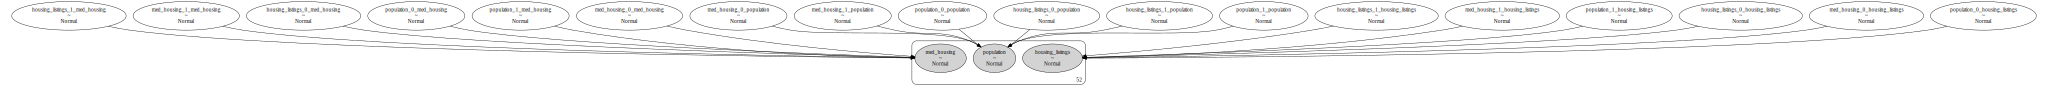

In [8]:
sig = 1000
with pm.Model() as model_comb:
	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	population_0_med_housing = pm.Normal(name='population_0_med_housing', mu=0, sigma=sig)
	population_1_med_housing = pm.Normal(name='population_1_med_housing', mu=0, sigma=sig)

	theta_med_housing = (
		med_housing_0_med_housing*input.med_housing_0+
		med_housing_1_med_housing*input.med_housing_1+
		housing_listings_0_med_housing*input.housing_listings_0+
		housing_listings_1_med_housing*input.housing_listings_1+
		population_0_med_housing*input.population_0+
		population_1_med_housing*input.population_1
	)
	med_housing = pm.Normal('med_housing', theta_med_housing, sd=200, observed=input.med_housing)

	# housing_listings
	med_housing_0_housing_listings = pm.Normal(name='med_housing_0_housing_listings', mu=0, sigma=sig)
	med_housing_1_housing_listings = pm.Normal(name='med_housing_1_housing_listings', mu=0, sigma=sig)
	housing_listings_0_housing_listings = pm.Normal(name='housing_listings_0_housing_listings', mu=0, sigma=sig)
	housing_listings_1_housing_listings = pm.Normal(name='housing_listings_1_housing_listings', mu=0, sigma=sig)
	population_0_housing_listings = pm.Normal(name='population_0_housing_listings', mu=0, sigma=sig)
	population_1_housing_listings = pm.Normal(name='population_1_housing_listings', mu=0, sigma=sig)

	theta_housing_listings = (
		med_housing_0_housing_listings*input.med_housing_0+
		med_housing_1_housing_listings*input.med_housing_1+
		housing_listings_0_housing_listings*input.housing_listings_0+
		housing_listings_1_housing_listings*input.housing_listings_1+
		population_0_housing_listings*input.population_0+
		population_1_housing_listings*input.population_1
	)
	housing_listings = pm.Normal('housing_listings', theta_housing_listings, sd=200, observed=input.housing_listings)

	# population
	med_housing_0_population = pm.Normal(name='med_housing_0_population', mu=0, sigma=sig)
	med_housing_1_population = pm.Normal(name='med_housing_1_population', mu=0, sigma=sig)
	housing_listings_0_population = pm.Normal(name='housing_listings_0_population', mu=0, sigma=sig)
	housing_listings_1_population = pm.Normal(name='housing_listings_1_population', mu=0, sigma=sig)
	population_0_population = pm.Normal(name='population_0_population', mu=0, sigma=sig)
	population_1_population = pm.Normal(name='population_1_population', mu=0, sigma=sig)

	theta_population = (
		med_housing_0_population*input.med_housing_0+
		med_housing_1_population*input.med_housing_1+
		housing_listings_0_population*input.housing_listings_0+
		housing_listings_1_population*input.housing_listings_1+
		population_0_population*input.population_0+
		population_1_population*input.population_1
	)
	population = pm.Normal('population', theta_population, sd=200, observed=input.population)
pm.model_to_graphviz(model_comb)

In [10]:
with model_comb:
    comb_trace = pm.sample(100)
    comb_idata = az.from_pymc3(comb_trace)
post_parameters = az.summary(comb_idata, round_to=2)
post_parameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [population_1_population, population_0_population, housing_listings_1_population, housing_listings_0_population, med_housing_1_population, med_housing_0_population, population_1_housing_listings, population_0_housing_listings, housing_listings_1_housing_listings, housing_listings_0_housing_listings, med_housing_1_housing_listings, med_housing_0_housing_listings, population_1_med_housing, population_0_med_housing, housing_listings_1_med_housing, housing_listings_0_med_housing, med_housing_1_med_housing, med_housing_0_med_housing]


/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)


ValueError: ignored

### Generate predictions

In [ ]:
# Get prediction data for 2021

cville.query("year == 2020")

city = cville.city.loc[len(cville)-1]
year = cville.year.loc[len(cville)-1]

pop0 = cville.popestimate_census1.loc[len(cville)-1]
pop1 = cville.popestimate_census.loc[len(cville)-1]

zhvi0 = cville.med_zhvi1.loc[len(cville)-1]
zhvi1 = cville.med_zhvi.loc[len(cville)-1]

deaths0 = cville.deaths_census1.loc[len(cville)-1]
deaths1 = cville.deaths_census.loc[len(cville)-1]

series = pd.Series({
    'city':city,
    'year':year,
    'popestimate_census0':pop0,
    'popestimate_census1':pop1,
    'med_zhvi0':zhvi0,
    'med_zhvi1':zhvi1,
    'deaths_census0':deaths0,
    'deaths_census1':deaths1
})

df_pred = pd.DataFrame(series).transpose()
df_pred

# Idea: Generate predictions via manual sampling from the posterior parameters

In [ ]:
parameters = post_parameters.reset_index()[['index','mean','sd']]
pop_params = ['pop0_pop','pop1_pop','zvhi0_pop','zvhi1_pop','death0_pop','death1_pop']
parameters = parameters[parameters['index'].isin(pop_params)].reset_index(drop=True)
parameters

In [ ]:
samples = 100000

pred_cols = list(df_pred.columns)[2:]
# print(pred_cols)

predictions = np.zeros(samples)

# Generate sample for population prediction
for i in range(len(parameters)):
  # print(parameters['index'].loc[i])
  mu = parameters['mean'].loc[i]
  sigma = parameters['sd'].loc[i]

  predictions += (np.random.normal(mu, sigma, samples)*df_pred[pred_cols[i]].loc[0])

print("Average:", round(np.average(predictions),2))
print("StDev:", round(np.std(predictions),2))

In [ ]:
def get_initial_prediction_input(df, year):
  """Generate prediction input dataframe for a specific year"""

  df = df.query(F"year == {year}").reset_index(drop=True)

  city = df.city.loc[len(df)-1]
  year = df.year.loc[len(df)-1]

  pop0 = df.popestimate_census1.loc[len(df)-1]
  pop1 = df.popestimate_census.loc[len(df)-1]

  zhvi0 = df.med_zhvi1.loc[len(df)-1]
  zhvi1 = df.med_zhvi.loc[len(df)-1]

  deaths0 = df.deaths_census1.loc[len(df)-1]
  deaths1 = df.deaths_census.loc[len(df)-1]

  series = pd.Series({
      'city':city,
      'year':year,
      'popestimate_census0':pop0,
      'popestimate_census1':pop1,
      'med_zhvi0':zhvi0,
      'med_zhvi1':zhvi1,
      'deaths_census0':deaths0,
      'deaths_census1':deaths1
  })

  df_pred = pd.DataFrame(series).transpose()
  return df_pred

get_initial_prediction_input(df=cville, year=2020)

In [ ]:
cville

In [ ]:
def get_predictions(df, year, post_parameters, prediction_suffixes, predictor_fields, order, samples=1000, first=True, df_std=pd.DataFrame()):
  """
  Generates posterior predictions for each year for a given number of steps
  May need to update this to make sure it doesn't give us non-negative estimates?
  Make some of the parameters in the model only self-dependent if it makes sense intuitively. Death won't depend on housing price for example. 
  Update for flexbility on order of autoregression
  
  """

  parameters = post_parameters.reset_index()[['index','mean','sd']]  
  city = df.city.loc[0]

  if first:
    df_pred = get_initial_prediction_input(df=df, year=year)
  else:
    df_pred = df

  # Set an empty series to add previous information to 
  next = pd.Series()

  # Set an empy series frame to add standard deviations to 
  stdevs = pd.Series()

  # Update next with information for the next prediction
  temp = (df_pred[[i for i in df_pred.columns if i not in ['city','year']]])
  max_order = order-1
  
  column_names = []
  new_values = []

  # Get all the columns we want to preserve
  for col in temp.columns:
    if any(x in [str(i) for i in range(1,max_order+1)] for x in col):
      column_names.append(col)
      new_values.append(temp[col].loc[len(temp)-1])

  # Set the new columns names
  new_columns = []
  for col in column_names:
    new_col = ''
    for i in col:
      # print(i)
      if i in ['1','2','3','4','5','6','7','8','9']:
        u = str(int(i)-1)
        new_col += u
      else:
        new_col += i
    new_columns.append(new_col)

  count = 0
  for i in new_columns:
    next[i] = new_values[count]
    count += 1
  next = (pd.DataFrame(next).transpose())
  next.insert(0, 'city',city)
  next.insert(1, 'year',year+1)
  # print(next)


  next_step_columns = []
  for col in new_columns:
    for i in col:
      if i in ['0','1','2','3','4','5','6','7','8','9']:
        if col.replace(i, str(max_order)) not in next_step_columns:
          next_step_columns.append(col.replace(i, str(max_order)))
  # print("next step", next_step_columns)


  # Generate sampled predictions
  next_values = []
  count = 0
  # Cycle through parameter names/suffixes
  for suffix in prediction_suffixes:
    
    # Generate parameter names for that suffix
    pop_params = [i for i in parameters['index'] if suffix in i]
    parameters_df = parameters[parameters['index'].isin(pop_params)].reset_index(drop=True)

    # Get a list of the columns for our input that we'll be cycling through 
    pred_cols = [col for col in df_pred if col not in ['city','year'] and 'std' not in col]

    # Initialize an array to update with our samples
    predictions = np.zeros(samples)

    # Generate sample for prediction by cycling through parameters and column names
    for i in range(len(parameters_df)):

      # Set mean and sigma
      mu = parameters_df['mean'].loc[i]
      sigma = parameters_df['sd'].loc[i]

      # Get a draw from a normal distribution and update the prediction array
      if first or pred_cols[i] not in df_std.columns:
        predictions += (np.random.normal(mu, sigma, samples)*df_pred[pred_cols[i]].loc[len(df_pred)-1])
      else:
        predictions += (np.random.normal(mu, sigma, samples)*(np.random.normal(df_pred[pred_cols[i]].loc[len(df_pred)-1], df_std[pred_cols[i]].loc[len(df_pred)-1], samples)))

    next[next_step_columns[count]] = round(np.average(predictions),2)
    stdevs[next_step_columns[count]] = round(np.std(predictions),2)

    count += 1

  stdevs = pd.DataFrame(stdevs).transpose()
  stdevs.insert(0, 'field', 'stdev')
  stdevs.insert(1, 'city', city)
  stdevs.insert(2, 'year', year+1)

  if not first:
    next = pd.concat([df_pred, next])
    stdevs = pd.concat([df_std, stdevs])

  return next, stdevs

df1, df2 = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)
df1

### Test out multiple iterations

In [ ]:
temp, stds = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)

new_pred, new_std = get_predictions(df=temp, year=2021, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=stds)

pred3, std3 = get_predictions(df=new_pred, year=2022, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=new_std)
pred3

In [ ]:
new_std

* Build out posterior predictive sampling
* Process to feed posterior prediction back into autoregression
* Model for top 5 MSAs
  * Function that takes in MSA name, and predictors, and ouputs formatted dataframe
  * Function that builds model to give autoregression posterior predictive parameters
  * 
* Process to join top 5 MSA model to city specific data
* Visuals of output